# 2. DCF modeling
### 2.1. Forecast Revenue

JAvitasi terv, ah mindenhol median-t hasznalsz...

effektiv tax rate zuros kerdes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [2]:
#load data
path_data = '../input/TEST_K_exp.csv'
data = pd.read_csv(path_data, sep=';', parse_dates=[2])
# filter data
report = 'K'
start_date = pd.Timestamp('2016-06-01')
data_filt = data.loc[(data['report'] == report) & (data['date'] > start_date), :]

data_filt.reset_index(drop=True, inplace=True)

In [3]:
data_filt.head()

,ticker,report,date,rev,cost_sale,r_d,sale_gen_adm,inpairm,other_charg,op_income,...,short_debt,acc_pay,other_curr_liab,tot_curr_liab,tot_long_debt,other_liab,tot_equity,tot_liab,depr_amort,stock_b_comp
0,TEST,K,2018-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,90,11237,2924,19926,6487,1314,13103,27727,NaN,NaN
1,TEST,K,2019-09-01,152703.0,132886.0,NaN,13502.0,NaN,NaN,4737.0,...,1699,11679,3792,23237,5124,1455,15584,29816,1492.0,595.0
2,TEST,K,2020-08-30,166761.0,144939.0,NaN,14687.0,NaN,NaN,5435.0,...,95,14172,3728,24844,7514,1935,18705,36851,1645.0,619.0
3,TEST,K,2021-08-29,195929.0,170684.0,NaN,16680.0,NaN,NaN,6708.0,...,799,16278,4561,29441,6692,2415,18078,41190,1781.0,665.0


In [4]:
for column in data_filt.columns[3:]:
    data_filt.loc[:, column] = data_filt.loc[:, column].astype('float')

# FIGYELJ a share darab szamra, h MM-ben legyen

In [5]:
data_filt['shares'] = data_filt['shares'] / 1000

I'll calculate some missing field

In [6]:
def calculate_missing_columns(df):
    df['ebitda'] = df['rev'] - df['cost_sale'] - df['sale_gen_adm'] - df['r_d'] - df['other_charg']
    df['ebit'] = df['ebitda'] - df['depr_amort']
    df['nopat'] = df['ebit'] - df['inc_tax_exp']
    df['other_curr_ass_lesscash'] = df['acc_rec'] + df['invent'] + df['other_curr_ass']
    df['tot_curr_liab_lessdebt'] = df['tot_curr_liab'] - df['short_debt']
    df['nwc'] = df['other_curr_ass_lesscash'] - df['tot_curr_liab_lessdebt']
    # capex calculation
    capex = []
    for index in range(len(df)):
        if index > 0:
            ppe_change = df['ppe_net'].iloc[index] - df['ppe_net'].iloc[index-1]
            depr_amort = df['depr_amort'].iloc[index]
            capex.append(ppe_change + depr_amort)
        else:
            capex.append(np.nan)
    df['capex'] = capex

    return df

In [7]:
data_filt = calculate_missing_columns(data_filt)
data_filt.head()

,ticker,report,date,rev,cost_sale,r_d,sale_gen_adm,inpairm,other_charg,op_income,...,tot_liab,depr_amort,stock_b_comp,ebitda,ebit,nopat,other_curr_ass_lesscash,tot_curr_liab_lessdebt,nwc,capex
0,TEST,K,2018-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27727.0,NaN,NaN,NaN,NaN,NaN,13030.0,19836.0,-6806.0,NaN
1,TEST,K,2019-09-01,152703.0,132886.0,NaN,13502.0,NaN,NaN,4737.0,...,29816.0,1492.0,595.0,NaN,NaN,NaN,14041.0,21538.0,-7497.0,2701.0
2,TEST,K,2020-08-30,166761.0,144939.0,NaN,14687.0,NaN,NaN,5435.0,...,36851.0,1645.0,619.0,NaN,NaN,NaN,14815.0,24749.0,-9934.0,2562.0
3,TEST,K,2021-08-29,195929.0,170684.0,NaN,16680.0,NaN,NaN,6708.0,...,41190.0,1781.0,665.0,NaN,NaN,NaN,17330.0,28642.0,-11312.0,3466.0


I use KEnji's estimate to reproduce calculations!!!!

I should find a sofisticated method....

In [8]:
kenji_rev_pred = [0.1, 0.1, 0.09, 0.07, 0.05]
prediction_revenue = []
for i, elem in enumerate(kenji_rev_pred):
    if i == 0:
        prediction_revenue.append(data_filt['rev'].iloc[-1] * (1 + elem))
    else:
        prediction_revenue.append(prediction_revenue[-1] * (1 + elem))
        
# df from results
prediction = pd.DataFrame(
    prediction_revenue,
    index=[i+1 for i in range(len(prediction_revenue))],
    columns=['rev']
)

In [9]:
prediction.head()

,rev
1,215521.900000
2,237074.090000
3,258410.758100
4,276499.511167
5,290324.486725


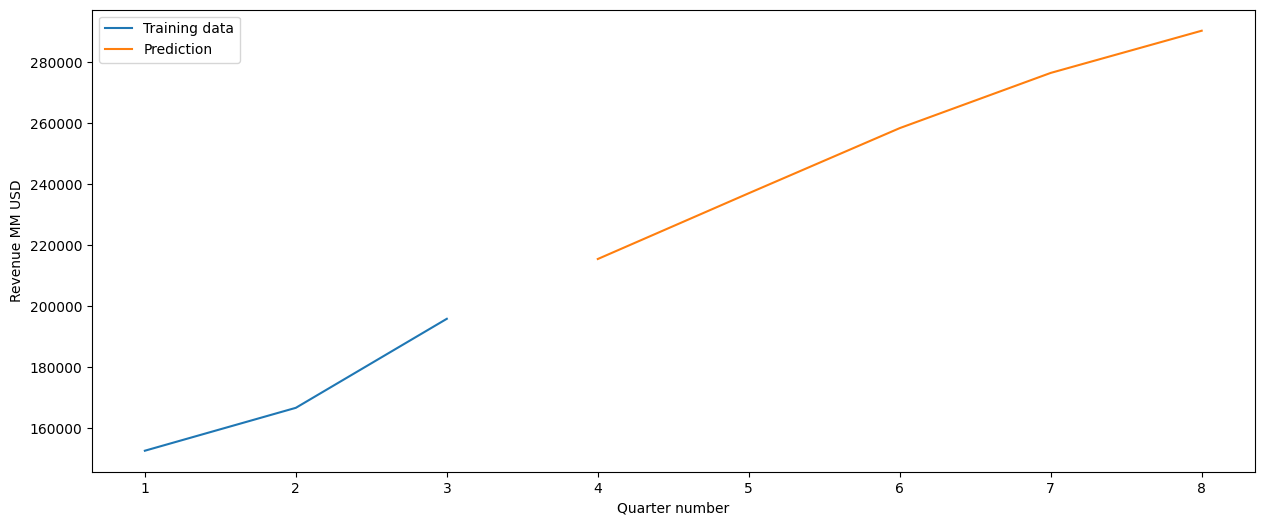

In [10]:
fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.plot(data_filt['rev'].index, data_filt['rev'].values, label='Training data')
ax1.plot(prediction.index+len(data_filt)-1, prediction['rev'], label='Prediction')

ax1.set_xlabel('Quarter number')
ax1.set_ylabel('Revenue MM USD')

plt.legend()
plt.show()

### 2.2. Calculate ratios

After the revenue prediction I calculate the expenses and use those to predict future CoS and EBITDA.

In [11]:
# create a function to calculate ratios
def calculate_margins(df, start_yrs_ago, close_yrs_ago):
    is_incomes = ['cost_sale', 'sale_gen_adm', 'r_d', 'other_charg']
    calc_margins = dict()
    # filter df with input dates
    df_filt = df.loc[
        (df.date > pd.to_datetime('today').normalize() - pd.Timedelta(days=start_yrs_ago*365)) &
        (df.date < pd.to_datetime('today').normalize() - pd.Timedelta(days=close_yrs_ago*365))
        , :]
    # plot and calculate ratios
    for income in is_incomes:
        if income != 'inc_tax_exp':
            div = 'rev'
        else:
            div = 'inc_b_tax'

        fig, ax1 = plt.subplots(figsize=(15, 6))

        ax1.plot(df_filt['date'], df_filt[income]/df_filt[div], label=income.replace('_', ' ').upper())
        ax1.axhline(y=(df_filt[income]/df_filt[div]).mean(), color='r', label='Average value')
        
        ax1.set_xlabel('Date')
        ax1.set_ylabel(income.replace('_', ' ').upper())
        
        plt.legend()
        plt.show()

        calc_margins[income+'_margin'] = (df_filt[income]/df_filt[div]).mean()

        print(str(income)+' is divided by the revenue.')
        print('Average value: '+str((df_filt[income]/df_filt[div]).mean()))

    return calc_margins

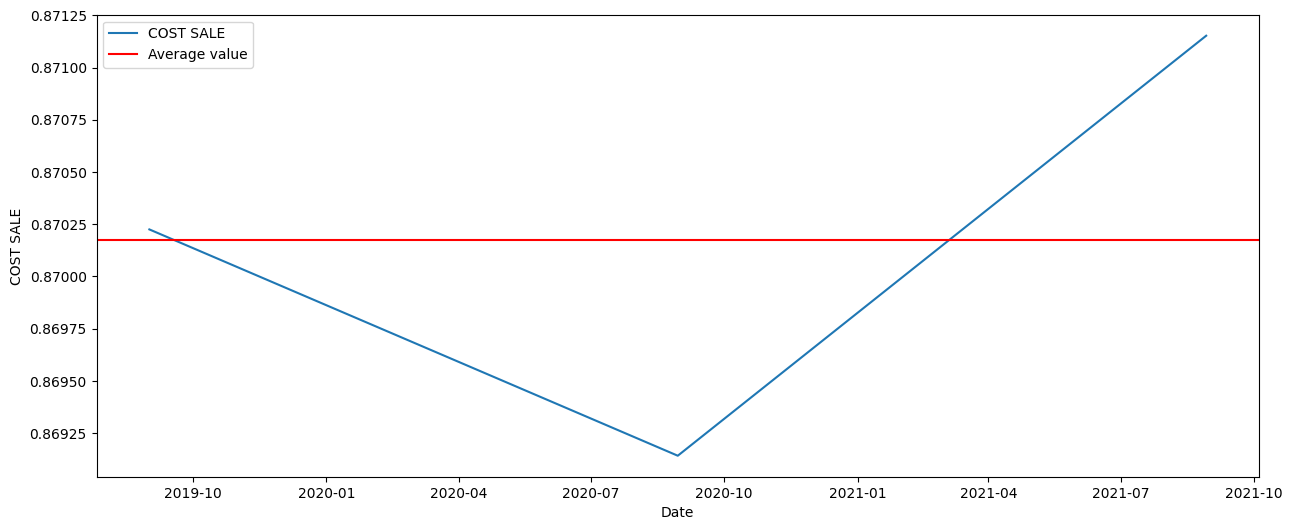

cost_sale is divided by the revenue.
Average value: 0.8701731930579152


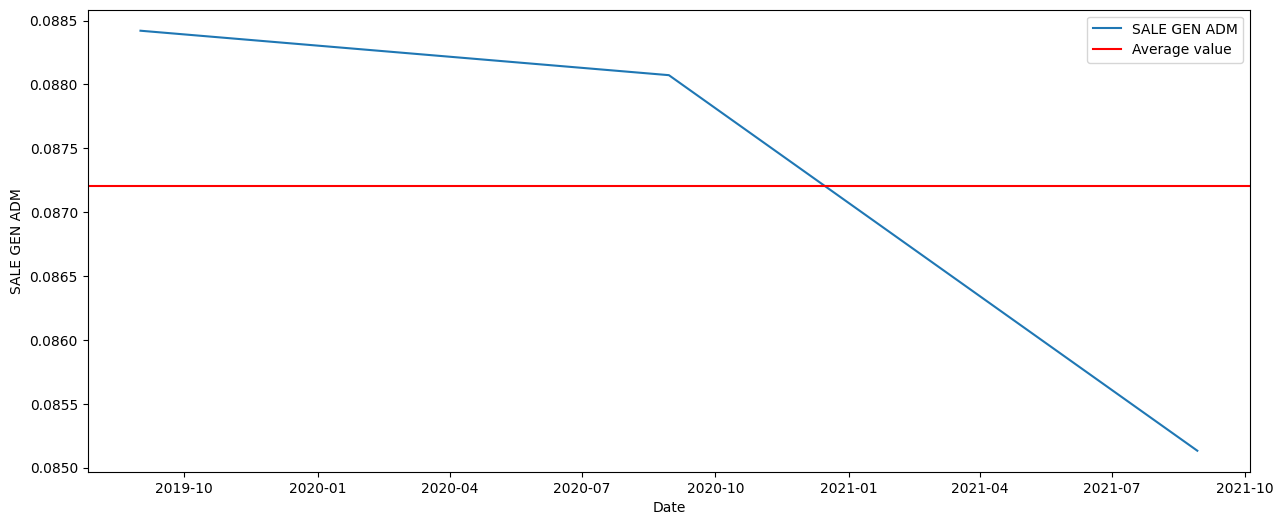

sale_gen_adm is divided by the revenue.
Average value: 0.08720834525870708


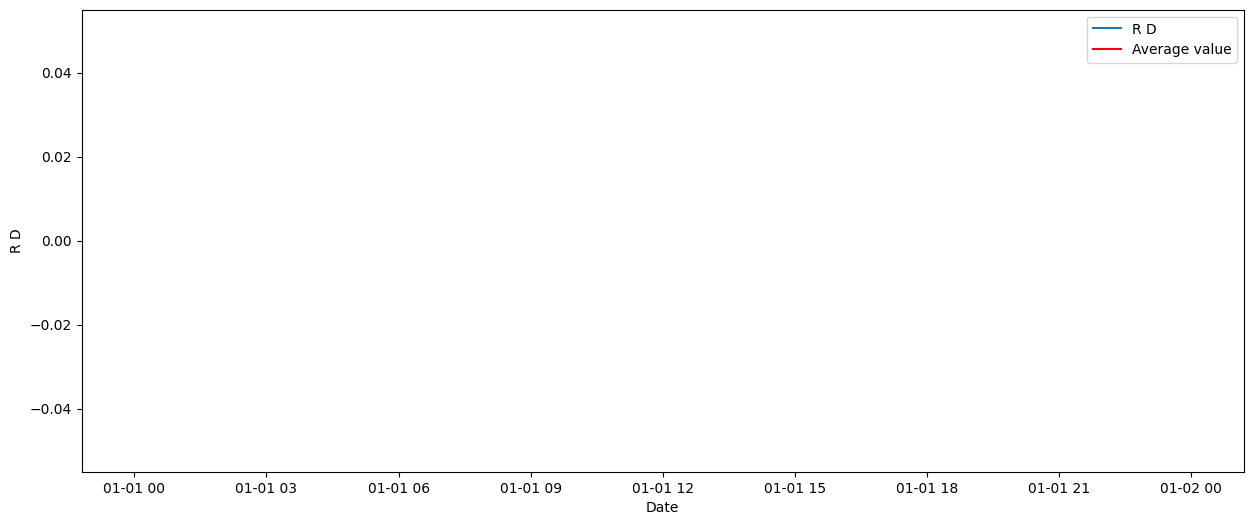

r_d is divided by the revenue.
Average value: nan


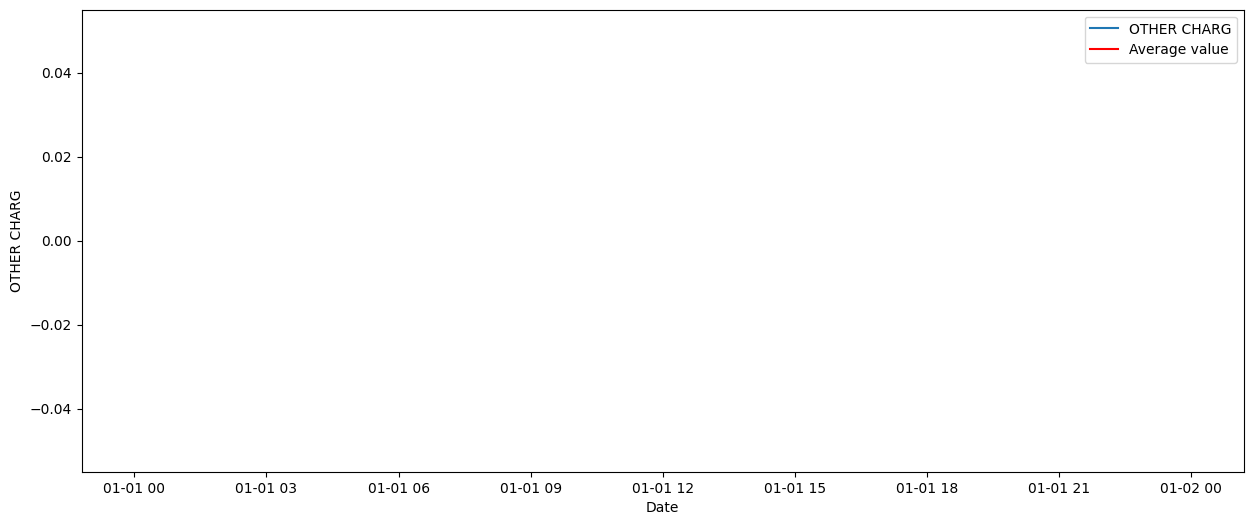

other_charg is divided by the revenue.
Average value: nan


In [12]:
start_yrs_ago = 19.5
close_yrs_ago = 0

base_case = calculate_margins(data_filt, start_yrs_ago, close_yrs_ago)

I update the average value dictionary (base_case) with Kenji's numbers

In [13]:
#base_case['cost_sale_margin'] = 0.87
#base_case['sale_gen_adm_margin'] = 0.088

In [14]:
#prediction['ebit'] = prediction['ebitda'] - prediction['depr_amort']
for column in ['cost_sale', 'sale_gen_adm', 'r_d', 'other_charg']:
    prediction[column] = prediction['rev'] * base_case[column+'_margin']

prediction.tail()

,rev,cost_sale,sale_gen_adm,r_d,other_charg
1,215521.900000,187541.379897,18795.308266,NaN,NaN
2,237074.090000,206295.517887,20674.839093,NaN,NaN
3,258410.758100,224862.114496,22535.574611,NaN,NaN
4,276499.511167,240602.462511,24113.064834,NaN,NaN
5,290324.486725,252632.585637,25318.718075,NaN,NaN


## 2.3. Calculate Fixed Assets

It's time to calculate D&A costs.

I will predict the PPE, D&A and CapEx values together.

In [15]:
fixed_asset = data_filt.loc[:, ['ppe_net', 'depr_amort']]

In [16]:
fixed_asset['ppe_net_start'] = [fixed_asset['ppe_net'].values[i-1] if i > 0 else np.nan for i, elem in enumerate(fixed_asset['ppe_net'].values)]
fixed_asset['capex'] = fixed_asset['ppe_net'] - fixed_asset['ppe_net_start'] + fixed_asset['depr_amort']

In [17]:
fixed_asset.head()

,ppe_net,depr_amort,ppe_net_start,capex
0,19681.0,NaN,NaN,NaN
1,20890.0,1492.0,19681.0,2701.0
2,21807.0,1645.0,20890.0,2562.0
3,23492.0,1781.0,21807.0,3466.0


In [18]:
def fixed_asset_ratios():
    fixed_asset_ratios = dict()
    # D&A ratio
    for column in ['depr_amort', 'capex']:
        ratio = fixed_asset[column]/fixed_asset['ppe_net_start']
        ratio.hist()
        plt.show()
        fixed_asset_ratios[column+'_ratio'] = ratio.mean()
        print('Average value is', fixed_asset_ratios[column+'_ratio'])
    return fixed_asset_ratios


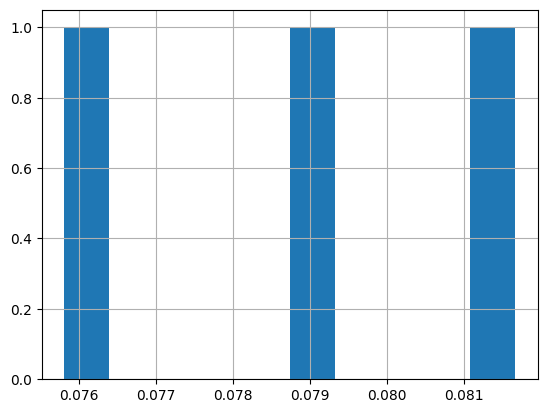

Average value is 0.07874199683260606


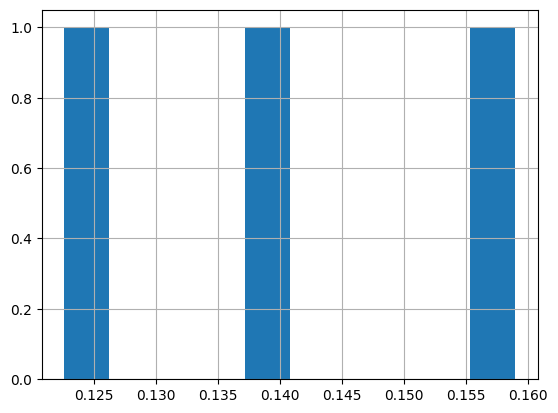

Average value is 0.13960705468273601


In [19]:
fxd_ass_ratios = fixed_asset_ratios()

If average vslues are far from distribution you can overwrite them with median.

I use Kenji's avg values to reprod his calculation


In [20]:
fxd_ass_ratios['depr_amort_ratio'] = 0.076
fxd_ass_ratios['capex_ratio'] = 0.15
fxd_ass_ratios

{'depr_amort_ratio': 0.076, 'capex_ratio': 0.15}

In [21]:
def predict_fixed_assets(raw_df, prediction_df, fxd_ass_ratios):
    ppe_start_pred = [raw_df['ppe_net'].iloc[-1]]
    depr_amort_pred = []
    capex_pred = []
    ppe_net = []
    for index in range(len(prediction_df)):
        depr_amort_pred.append(ppe_start_pred[-1] * fxd_ass_ratios['depr_amort_ratio'])
        capex_pred.append(ppe_start_pred[-1] * fxd_ass_ratios['capex_ratio'])
        ppe_net.append(ppe_start_pred[-1] - depr_amort_pred[-1] + capex_pred[-1])
        ppe_start_pred.append(ppe_net[-1])
    
    prediction_df['depr_amort'] = depr_amort_pred
    prediction_df['capex'] = capex_pred
    prediction_df['ppe_net'] = ppe_net
    return prediction_df

In [22]:
prediction = predict_fixed_assets(data_filt, prediction, fxd_ass_ratios)
prediction.head()

,rev,cost_sale,sale_gen_adm,r_d,other_charg,depr_amort,capex,ppe_net
1,215521.900000,187541.379897,18795.308266,NaN,NaN,1785.392000,3523.800000,25230.408000
2,237074.090000,206295.517887,20674.839093,NaN,NaN,1917.511008,3784.561200,27097.458192
3,258410.758100,224862.114496,22535.574611,NaN,NaN,2059.406823,4064.618729,29102.670098
4,276499.511167,240602.462511,24113.064834,NaN,NaN,2211.802927,4365.400515,31256.267685
5,290324.486725,252632.585637,25318.718075,NaN,NaN,2375.476344,4688.440153,33569.231494


## 2.4. Calculate EBITDA, EBIT, NOPAT

I use the first function

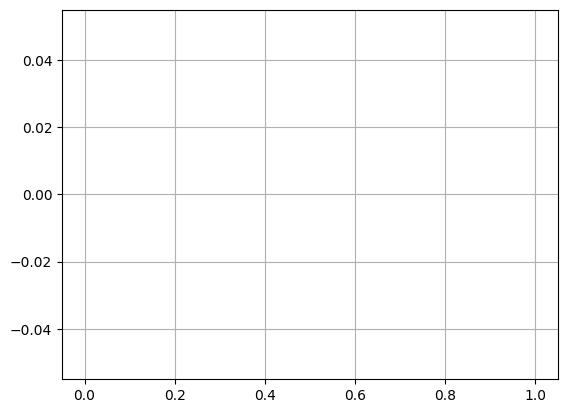

Effective tax rate is nan


In [23]:
# calculate and plot eff tax rate
eff_tax_rate = (data_filt['inc_tax_exp']/data_filt['ebit']).mean()
(data_filt['inc_tax_exp']/data_filt['ebit']).hist(range=[0, 1])
plt.show()
print('Effective tax rate is', eff_tax_rate)
# From 2017 the tax rate was reduced to 21% from 35%
eff_tax_rate = 0.21

In [24]:
def calculate_ebitda_ebit_nopat(raw_df, prediction_df, eff_tax_rate):
    # if R&D or Other expenses missing itt will add nan, I hae to replace nan with 0
    prediction_df['r_d'] = prediction_df['r_d'].fillna(0.0)
    prediction_df['other_charg'] = prediction_df['other_charg'].fillna(0.0)
    prediction_df['ebitda'] = prediction_df['rev'] - prediction_df['cost_sale'] - prediction_df['sale_gen_adm'] - prediction_df['r_d'] - prediction_df['other_charg']
    prediction_df['ebit'] = prediction_df['ebitda'] - prediction_df['depr_amort']
    prediction_df['nopat'] = prediction_df['ebit'] - (prediction_df['ebit'] * eff_tax_rate)
    return prediction_df

In [25]:
prediction = calculate_ebitda_ebit_nopat(data_filt, prediction, eff_tax_rate)
prediction.head()

,rev,cost_sale,sale_gen_adm,r_d,other_charg,depr_amort,capex,ppe_net,ebitda,ebit,nopat
1,215521.900000,187541.379897,18795.308266,0.0,0.0,1785.392000,3523.800000,25230.408000,9185.211837,7399.819837,5845.857671
2,237074.090000,206295.517887,20674.839093,0.0,0.0,1917.511008,3784.561200,27097.458192,10103.733021,8186.222013,6467.115390
3,258410.758100,224862.114496,22535.574611,0.0,0.0,2059.406823,4064.618729,29102.670098,11013.068993,8953.662170,7073.393114
4,276499.511167,240602.462511,24113.064834,0.0,0.0,2211.802927,4365.400515,31256.267685,11783.983822,9572.180895,7562.022907
5,290324.486725,252632.585637,25318.718075,0.0,0.0,2375.476344,4688.440153,33569.231494,12373.183013,9997.706669,7898.188269


## 2.5. Function to plot Prediction vs Historical data

In [26]:
def plot_hist_pred(hist_df, pred_df):
    # reset index
    pred_df.index = pred_df.index + hist_df.index[-1]
    
    for column in pred_df.columns:
        try:
            fig, ax1 = plt.subplots(figsize=(15, 6))

            ax1.plot(hist_df.index, hist_df[column], color='k', label='Historical data')
            ax1.plot(pred_df.index, pred_df[column], color='r', label='Predicted values')

            ax1.set_xlabel('Index')
            ax1.set_ylabel(column.replace('_', ' ').upper())

            plt.legend()
            plt.show()
        except:
            continue

## 2.6. Calculate Net Working Capital

To get this we have to forecast the current assets and liabilities.
I will use ratios to predict them:
- Days Sales Outstanding (dso) --> (Account recivable / Revenue) * 360
- Days Inventory Out. (dio) --> (Inventory / Cost of General Sale) * 360
- Other current assets per revenue (oca_rev) --> Other current assets / revenue
- Current liabilities per revenue (tcl_rec) --> (Total current liabilities - current debt) / revenue

In [27]:
nwc = data_filt.loc[:, ['rev', 'cost_sale', 'cash_cash_eq', 'acc_rec', 'invent', 'other_curr_ass', 'tot_curr_ass', 'acc_pay', 'short_debt', 'tot_curr_liab']]
nwc.columns

Index(['rev', 'cost_sale', 'cash_cash_eq', 'acc_rec', 'invent',
       'other_curr_ass', 'tot_curr_ass', 'acc_pay', 'short_debt',
       'tot_curr_liab'],
      dtype='object')

In [28]:
def calculate_nwc_ratios(df):
    result = dict()
    # Days Sales Outstanding (dso)
    dso = (df['acc_rec'] / df['rev']) * 360
    dso.hist()
    plt.show()
    result['dso'] = dso.mean()
    print('DSO:', result['dso'])

    #Days Inventory Out. (dis)
    dio = (df['invent'] / df['cost_sale']) * 360
    dio.hist()
    plt.show()
    result['dio'] = dio.mean()
    print('DIO:', result['dio'])

    #Days Payable Out. (dpo)
    dpo = (df['acc_pay'] / df['cost_sale']) * 360
    dpo.hist()
    plt.show()
    result['dpo'] = dpo.mean()
    print('DPO:', result['dpo'])


    #Sum of Other current assets per revenue --> soca_rev
    # calculate the non cach non accoint recivable and inventory total current assets ratio to revenue
    soca_rev = (df['tot_curr_ass'] - df['acc_rec'] - df['invent'] - df['cash_cash_eq']) / df['rev']
    soca_rev.hist()
    plt.show()
    result['soca_rev'] = soca_rev.mean()
    print('Sum Other Current Assets:', result['soca_rev'])

    #Sum of Other current liabilities per revenue --> socl_rev
    # calculate the non current debt non account payable total current liabilities ratio to revenue
    socl_rev = (df['tot_curr_liab'] - df['short_debt'] - df['acc_pay']) / df['rev']
    socl_rev.hist()
    plt.show()
    result['socl_rev'] = socl_rev.mean()
    print('Sum Other Current Liabilities per Rec', result['socl_rev'])
    
    return result

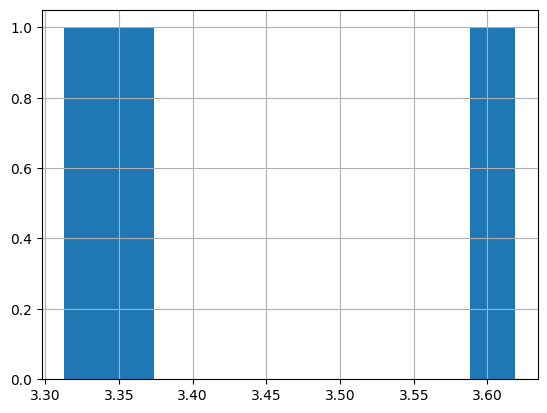

DSO: 3.425909409499862


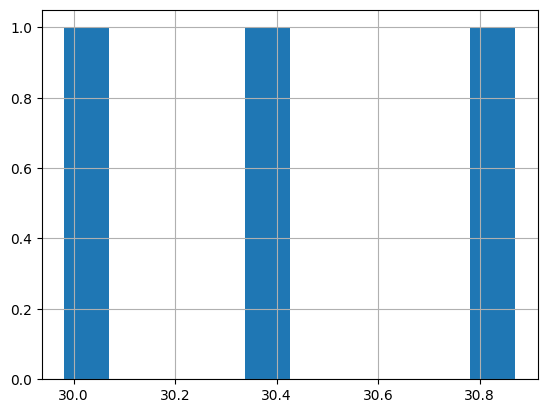

DIO: 30.41950417216484


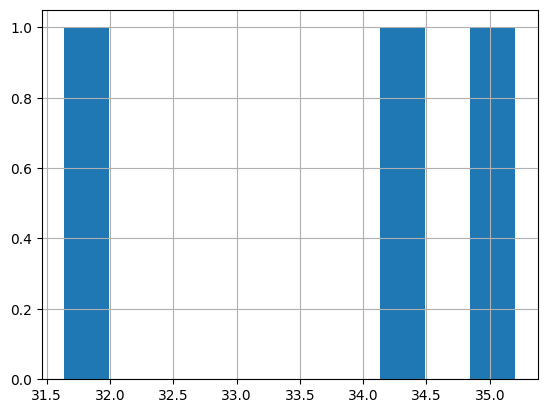

DPO: 33.72427777071743


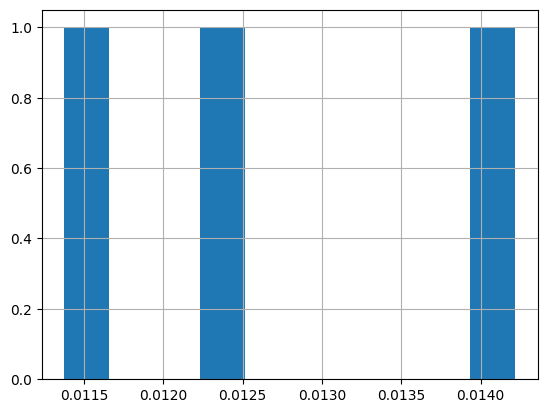

Sum Other Current Assets: 0.01263091643011211


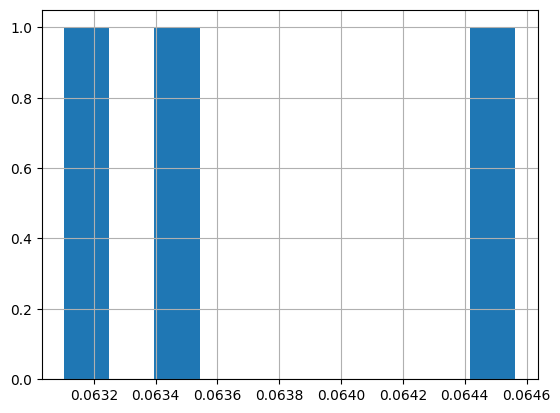

Sum Other Current Liabilities per Rec 0.06369794329791832


In [29]:
nwc_ratios = calculate_nwc_ratios(nwc)

In [30]:
def predict_curr_ass_liab(df_prediction, nwc_ratios):
    df_prediction['acc_rec'] = (df_prediction['rev'] * nwc_ratios['dso']) / 360
    df_prediction['invent'] = (df_prediction['cost_sale'] * nwc_ratios['dio']) / 360
    df_prediction['acc_pay'] = (df_prediction['cost_sale'] * nwc_ratios['dpo']) / 360
    
    df_prediction['other_curr_ass_lesscash'] = df_prediction['acc_rec'] + df_prediction['invent'] + (df_prediction['rev'] * nwc_ratios['soca_rev'])
    df_prediction['tot_curr_liab_lessdebt'] = df_prediction['acc_pay'] + (df_prediction['rev'] * nwc_ratios['socl_rev'])
    df_prediction['nwc'] = df_prediction['other_curr_ass_lesscash'] - df_prediction['tot_curr_liab_lessdebt']
    return df_prediction 

In [31]:
prediction = predict_curr_ass_liab(prediction, nwc_ratios)
prediction.head()

,rev,cost_sale,sale_gen_adm,r_d,other_charg,depr_amort,capex,ppe_net,ebitda,ebit,nopat,acc_rec,invent,acc_pay,other_curr_ass_lesscash,tot_curr_liab_lessdebt,nwc
1,215521.900000,187541.379897,18795.308266,0.0,0.0,1785.392000,3523.800000,25230.408000,9185.211837,7399.819837,5845.857671,2050.995848,15846.988301,17568.604414,20620.223256,31296.906180,-10676.682924
2,237074.090000,206295.517887,20674.839093,0.0,0.0,1917.511008,3784.561200,27097.458192,10103.733021,8186.222013,6467.115390,2256.095432,17431.687131,19325.464856,22682.245582,34426.596798,-11744.351216
3,258410.758100,224862.114496,22535.574611,0.0,0.0,2059.406823,4064.618729,29102.670098,11013.068993,8953.662170,7073.393114,2459.144021,19000.538972,21064.756693,24723.647684,37524.990510,-12801.342826
4,276499.511167,240602.462511,24113.064834,0.0,0.0,2211.802927,4365.400515,31256.267685,11783.983822,9572.180895,7562.022907,2631.284103,20330.576701,22539.289661,26454.303022,40151.739845,-13697.436824
5,290324.486725,252632.585637,25318.718075,0.0,0.0,2375.476344,4688.440153,33569.231494,12373.183013,9997.706669,7898.188269,2762.848308,21347.105536,23666.254144,27777.018173,42159.326838,-14382.308665


## 2.7. Change in NWC

In [32]:
def calc_change_nwc(df_hist, df_predict):
    c_nwc = []
    
    if df_hist.equals(df_predict):
        for index in range(len(df_predict)):
            if index > 0:
                c_nwc.append(df_predict['nwc'].iloc[index] - df_predict['nwc'].iloc[index-1])
            else:
                c_nwc.append(np.nan)
    else:
        for index in range(len(df_predict)):
            if index > 0:
                c_nwc.append(df_predict['nwc'].iloc[index] - df_predict['nwc'].iloc[index-1])
            else:
                c_nwc.append(df_predict['nwc'].iloc[index] - df_hist['nwc'].iloc[-1])
    
    df_predict['c_nwc'] = c_nwc
    
    return df_predict

In [33]:
prediction = calc_change_nwc(data_filt, prediction)
data_filt = calc_change_nwc(data_filt, data_filt)

In [34]:
def calc_unleveared_fcf(df):
    df['unlev_fcf'] = df['nopat'] + df['depr_amort'] - df['capex'] - df['c_nwc']
    return df

In [35]:
prediction = calc_unleveared_fcf(prediction)
data_filt = calc_unleveared_fcf(data_filt)

## 2.8. Calculate Weighted Average Cost of Capital (WACC)

In [36]:
def calculate_wacc(df, share_price, eff_tax_rate, us_bond_10_yr, expected_return, beta):
    equity = (share_price * df['shares'].iloc[-1])
    debt = df['short_debt'].iloc[-1] + df['tot_long_debt'].iloc[-1]
    
    cost_of_debt = abs(df['int_exp'].iloc[-1]) / debt
    d_per_d_plus_e = debt / (debt + equity)
    after_tax_cost_of_debt = cost_of_debt * (1 - eff_tax_rate)

    risk_free_rate = us_bond_10_yr
    market_risk_premium = expected_return - risk_free_rate
    cost_of_equity = risk_free_rate + (beta * market_risk_premium)
    e_per_d_plus_e = equity / (debt + equity)
    
    wacc = (d_per_d_plus_e * after_tax_cost_of_debt) + (e_per_d_plus_e * cost_of_equity)
    return wacc

In [37]:
wacc = calculate_wacc(
    df=data_filt,
    share_price=500,
    eff_tax_rate=0.21,
    us_bond_10_yr=0.031,
    expected_return=0.078,
    beta=0.7)
print(wacc)

0.06240396709976313


## 2.9. Present value of FCF, Terminal Value & present value of TV

In [38]:
prediction.head()

,rev,cost_sale,sale_gen_adm,r_d,other_charg,depr_amort,capex,ppe_net,ebitda,ebit,nopat,acc_rec,invent,acc_pay,other_curr_ass_lesscash,tot_curr_liab_lessdebt,nwc,c_nwc,unlev_fcf
1,215521.900000,187541.379897,18795.308266,0.0,0.0,1785.392000,3523.800000,25230.408000,9185.211837,7399.819837,5845.857671,2050.995848,15846.988301,17568.604414,20620.223256,31296.906180,-10676.682924,635.317076,3472.132595
2,237074.090000,206295.517887,20674.839093,0.0,0.0,1917.511008,3784.561200,27097.458192,10103.733021,8186.222013,6467.115390,2256.095432,17431.687131,19325.464856,22682.245582,34426.596798,-11744.351216,-1067.668292,5667.733490
3,258410.758100,224862.114496,22535.574611,0.0,0.0,2059.406823,4064.618729,29102.670098,11013.068993,8953.662170,7073.393114,2459.144021,19000.538972,21064.756693,24723.647684,37524.990510,-12801.342826,-1056.991609,6125.172818
4,276499.511167,240602.462511,24113.064834,0.0,0.0,2211.802927,4365.400515,31256.267685,11783.983822,9572.180895,7562.022907,2631.284103,20330.576701,22539.289661,26454.303022,40151.739845,-13697.436824,-896.093998,6304.519317
5,290324.486725,252632.585637,25318.718075,0.0,0.0,2375.476344,4688.440153,33569.231494,12373.183013,9997.706669,7898.188269,2762.848308,21347.105536,23666.254144,27777.018173,42159.326838,-14382.308665,-684.871841,6270.096301


In [39]:
def calculate_present_value_fcf(df, report='Q'):
    if report == 'Q':
        multipl = 0.25
    else:
        multipl = 1
    # calculate present cahs flows
    df['pres_val_fcf'] = df['unlev_fcf']/((1+wacc)**(df.index*multipl))
    return df

In [40]:
prediction = calculate_present_value_fcf(prediction, report=0)
prediction.head()

,rev,cost_sale,sale_gen_adm,r_d,other_charg,depr_amort,capex,ppe_net,ebitda,ebit,nopat,acc_rec,invent,acc_pay,other_curr_ass_lesscash,tot_curr_liab_lessdebt,nwc,c_nwc,unlev_fcf,pres_val_fcf
1,215521.900000,187541.379897,18795.308266,0.0,0.0,1785.392000,3523.800000,25230.408000,9185.211837,7399.819837,5845.857671,2050.995848,15846.988301,17568.604414,20620.223256,31296.906180,-10676.682924,635.317076,3472.132595,3268.184893
2,237074.090000,206295.517887,20674.839093,0.0,0.0,1917.511008,3784.561200,27097.458192,10103.733021,8186.222013,6467.115390,2256.095432,17431.687131,19325.464856,22682.245582,34426.596798,-11744.351216,-1067.668292,5667.733490,5021.460527
3,258410.758100,224862.114496,22535.574611,0.0,0.0,2059.406823,4064.618729,29102.670098,11013.068993,8953.662170,7073.393114,2459.144021,19000.538972,21064.756693,24723.647684,37524.990510,-12801.342826,-1056.991609,6125.172818,5107.981261
4,276499.511167,240602.462511,24113.064834,0.0,0.0,2211.802927,4365.400515,31256.267685,11783.983822,9572.180895,7562.022907,2631.284103,20330.576701,22539.289661,26454.303022,40151.739845,-13697.436824,-896.093998,6304.519317,4948.724135
5,290324.486725,252632.585637,25318.718075,0.0,0.0,2375.476344,4688.440153,33569.231494,12373.183013,9997.706669,7898.188269,2762.848308,21347.105536,23666.254144,27777.018173,42159.326838,-14382.308665,-684.871841,6270.096301,4632.610557


## 2.10. Terminal Value and present value of TV

I use the perpetuity growth model

In [41]:
def calculate_tv_prestv_enterp_val(df, industry_growth_rate):
    # Terminal Value
    tv = ((df['unlev_fcf'].iloc[-1] * (1 + industry_growth_rate))) / (wacc - industry_growth_rate)
    # present value of TV
    pres_value_tv = tv / (1 + wacc)**5
    
    return tv, pres_value_tv

In [42]:
tv, pres_value_tv = calculate_tv_prestv_enterp_val(prediction, 0.03)
pres_value_tv

147253.2316520648

In [43]:
def calc_enterp_company_value(df_hist, df_pred, pres_value_tv):
    
    debt = df_hist['short_debt'].iloc[-1] + df_hist['tot_long_debt'].iloc[-1]
    
    if 'equity_minor_interest' in df_hist.columns:
        equity_minor_interest = df_hist['equity_minor_interest'].iloc[-1]
    else:
        equity_minor_interest = 0
    # Enterprise Values
    enterp_val = df_pred['pres_val_fcf'].sum() + pres_value_tv
    # Company Value
    comp_val = enterp_val + df_hist['cash_cash_eq'].iloc[-1] + df_hist['short_inv'].iloc[-1] - debt - equity_minor_interest
        
    return enterp_val, comp_val

In [44]:
enterp_val, equity_value = calc_enterp_company_value(data_filt, prediction, pres_value_tv)

In [45]:
def implied_share_price(equity_value, hist_df):
    share_price = equity_value / hist_df['shares'].iloc[-1]
    return share_price

In [46]:
fcst_share_price = implied_share_price(equity_value, data_filt)
fcst_share_price

393.64862747819006

In [47]:
#plot_hist_pred(data_filt, prediction)